This script demonstrates the metropolis hasings algorithm. We sample from a banana-like distribution to demonstrate how the process can crawl to find a thin manifold and then bounce around within a weirdly shaped distribution. 

We define a banana shaped distribution using a modification of the Rosenbrock function. 

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as norm
from sklearn.neighbors import KernelDensity
from matplotlib.animation import FuncAnimation


In [3]:
def rosen_density(x):
    """
    Defines a banana-like pdf. Make b larger to make narrower banana.
    Note: "pdf" is not normalized.
    """
    a = 1
    b = 10
    r = (a - x[0])**2 + b*(x[1] - x[0]**2)**2
    
    # use masks to represent vectorized if statements. This facilitates plotting. 
    mask1 = (r<1)
    mask2 = (r>=1)

    return np.exp(-r)*mask1 + 1/r*mask2 # if r < 1 else 1/r**2

Technical sidenote: Note that we exponentiate the Rosenbrock function on the 1-upper-level set and apply 1/t outside of this set. Not a huge deal, but it's to get nicer convergence properties. If you just exponentiate, then it's really hard for the process to move anywhere. It rejects all samples until you're lucky enough to get one in the banana. This is a side note, but it demonstrates how the process uses a form of local search to make progress. And if your distribution is nearly null, it doesn't work well. 

The distribution is visualized below. Note that this isn't actually a distribution per-se, since it's not normalized. But we'll still sample from the normalized distribution anyway. (I'm not sure why it looks so spikey.)

<IPython.core.display.Javascript object>


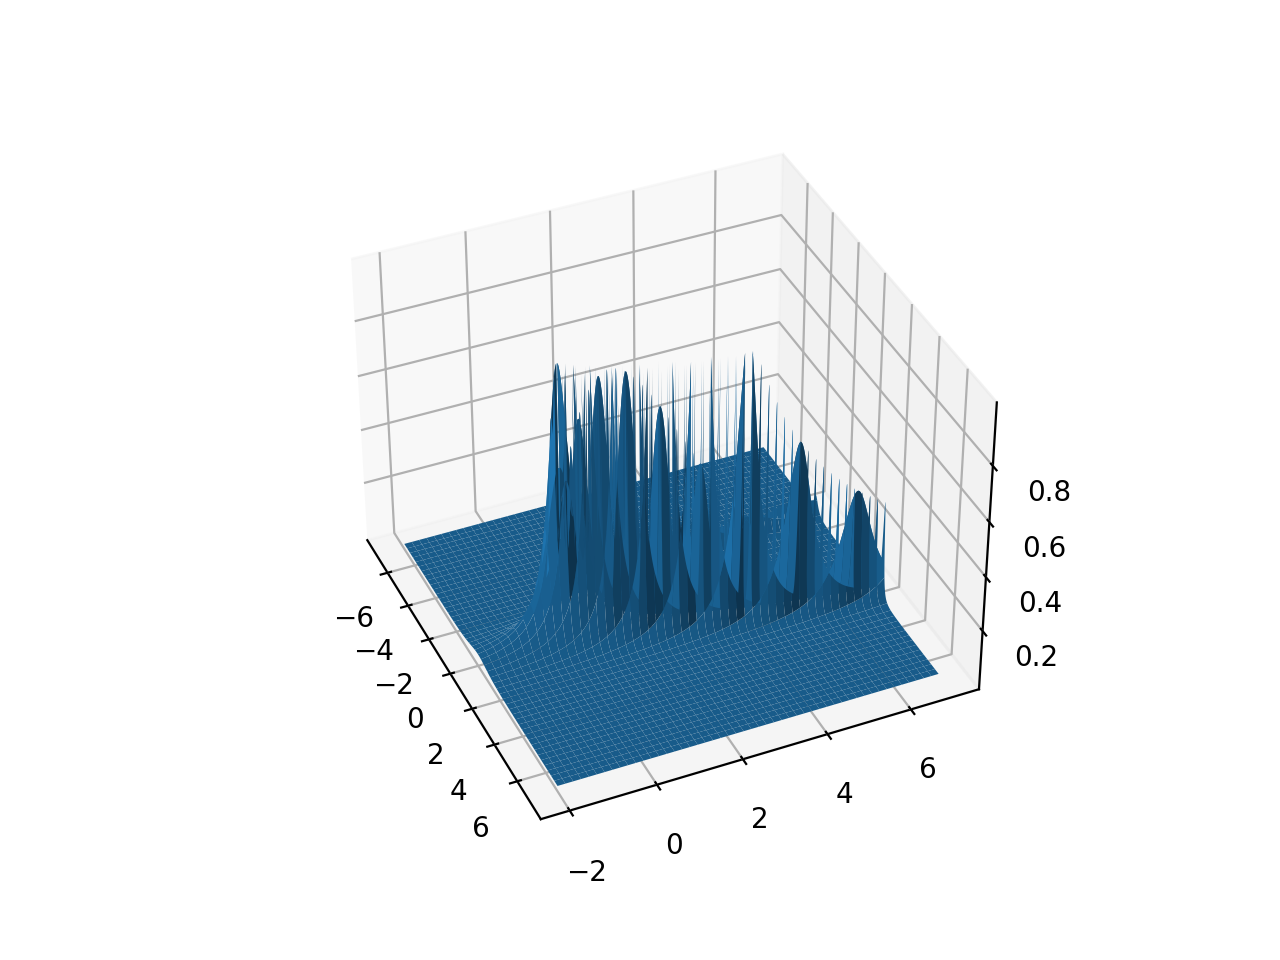

/var/folders/xb/4hhmcv5x1tx29d8pg1tqsjhc0000gn/T/ipykernel_50346/4200999090.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(111, projection='3d')


In [4]:
# visualize banana distribution
x = np.linspace(-7, 7, 10_000)
y = np.linspace(-2, 7, 10_000)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(num=1)
ax = plt.subplot(111, projection='3d')
ax.plot_surface(X, Y, rosen_density([X, Y]))
plt.show()

Now we apply the Metropolis Hastings algorithm

<IPython.core.display.Javascript object>


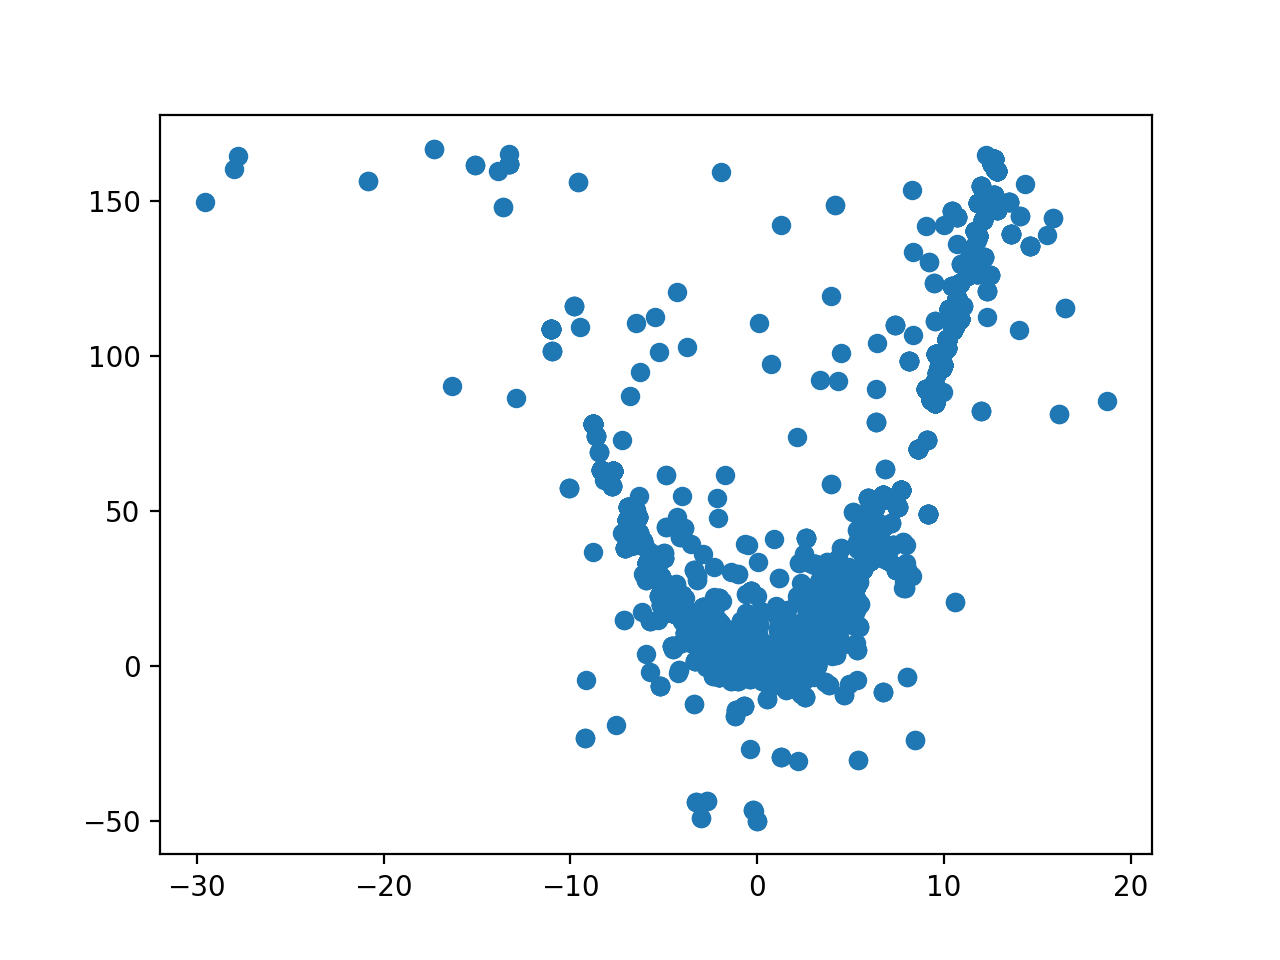

In [4]:
# parameters
n_steps = 10_000
sigma_proposal = 10  # width of proposal distribution

# define proposal distribution
cov = [[sigma_proposal, 0], [0, sigma_proposal]]
q = norm(cov=cov).pdf
#TODO: Add a visualization of q, just as a sanity check

# define target distribution
p = rosen_density

# track the points over time
x = np.zeros((n_steps, 2))

# initialization
x_current = np.array([0.0, -50.0])

for i in range(n_steps):
    # draw a sample from uniform
    u = np.random.uniform()

    # draw a sample from proposal distribution
    x_star = np.random.normal(loc=x_current, scale=sigma_proposal)

    accept_thresh = min(1, (p(x_star)*q(x_current - x_star))/(p(x_current)*q(x_star-x_current))) if p(x_current) > 0 else 0
    if u < accept_thresh:
        x_current = x_star

    x[i] = x_current

fig, ax = plt.subplots(num=2)
ax.scatter(x[:, 0], x[:, 1])

Next is an animation to show how sampling proceeds. I think this animation is useful to demonstrate how very \it{not iid} the sampling is. Seeing this in action, my intuition would not be to guess the ergodic theorem. 

<IPython.core.display.Javascript object>


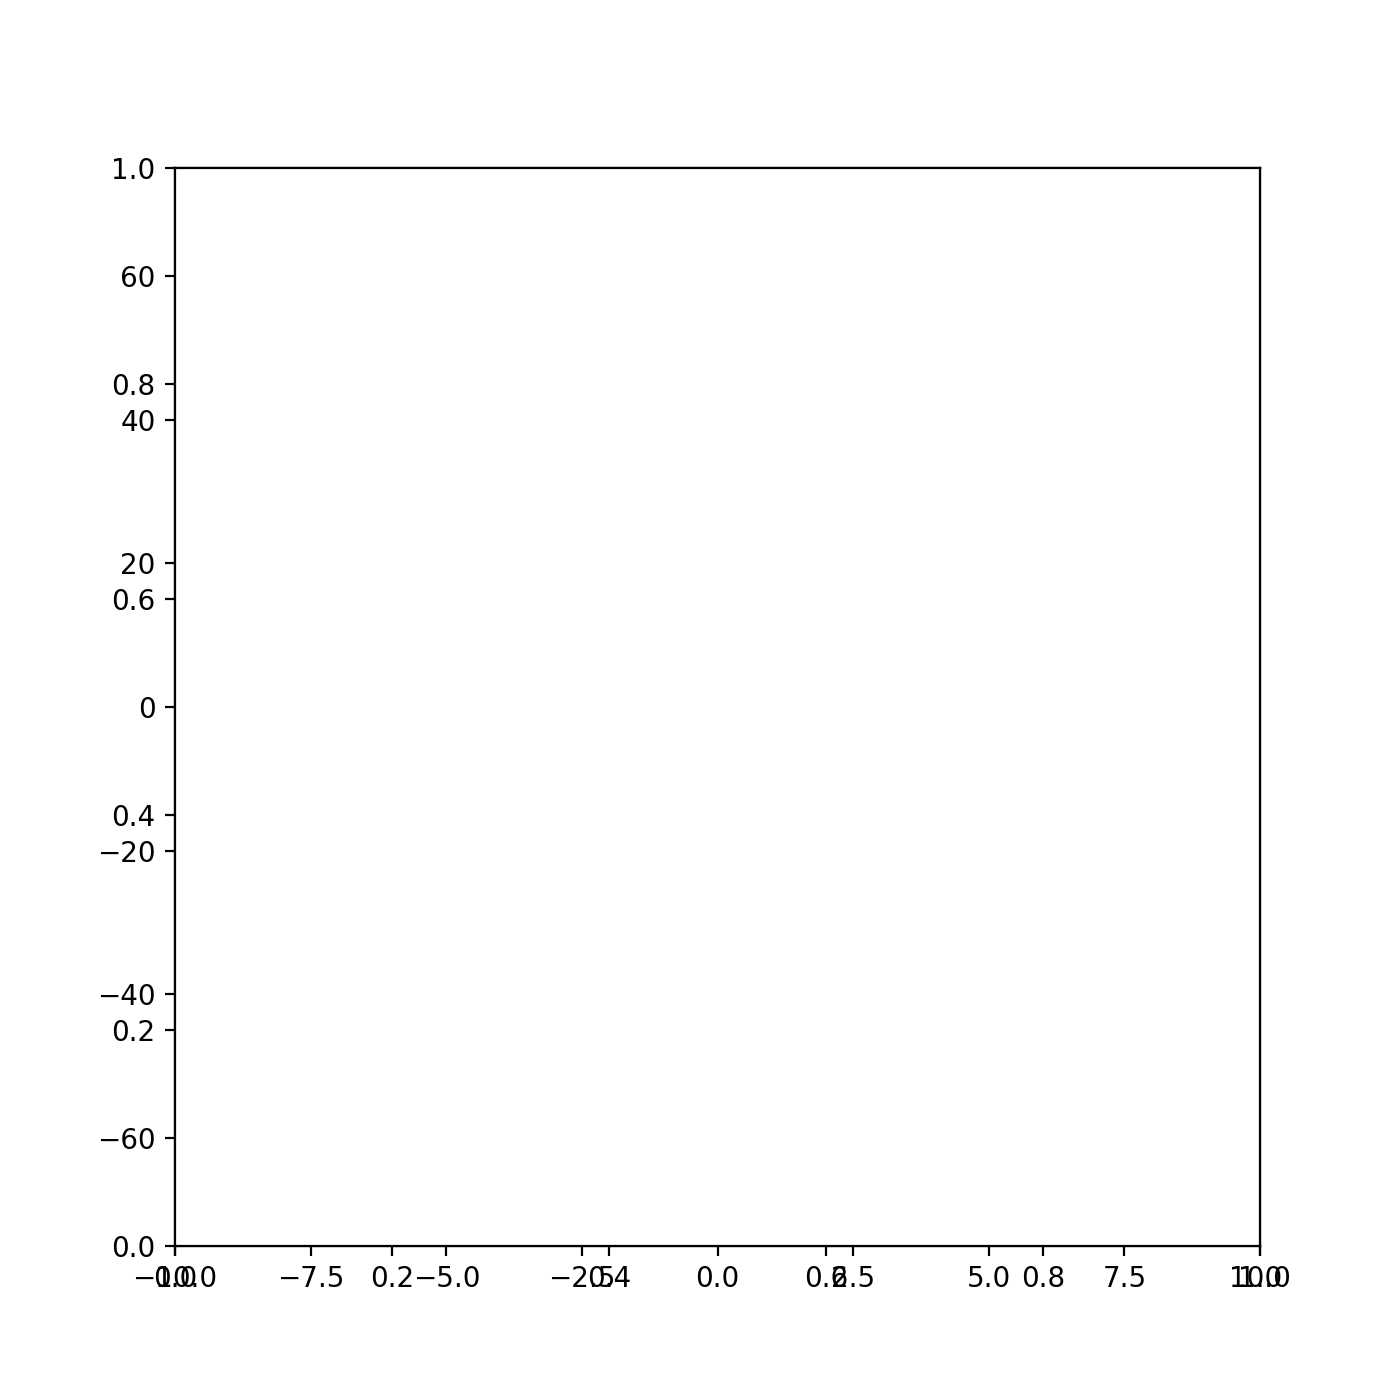

/var/folders/xb/4hhmcv5x1tx29d8pg1tqsjhc0000gn/T/ipykernel_50327/2597072648.py:15: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = FuncAnimation(fig, update, interval=50)


In [5]:
# animate the process
L = 5
n_plot_points = 50
fig = plt.figure(figsize=(7,7))
ax = plt.axes(xlim=(-10, 10), ylim=(-75, 75))
scatter=ax.scatter(x[:n_plot_points, 0], x[:n_plot_points, 1])

def update(i):
    k = 10
    scatter.set_offsets(x[k*i:k*i+n_plot_points])
    plt.title(f'i = {k*i}')
    return scatter,

fig, ax = plt.subplots(num=3)
anim = FuncAnimation(fig, update, interval=50)
plt.show()

Finally, here is a kernel density estimator of the distribution using the MCMC samples. 

<IPython.core.display.Javascript object>


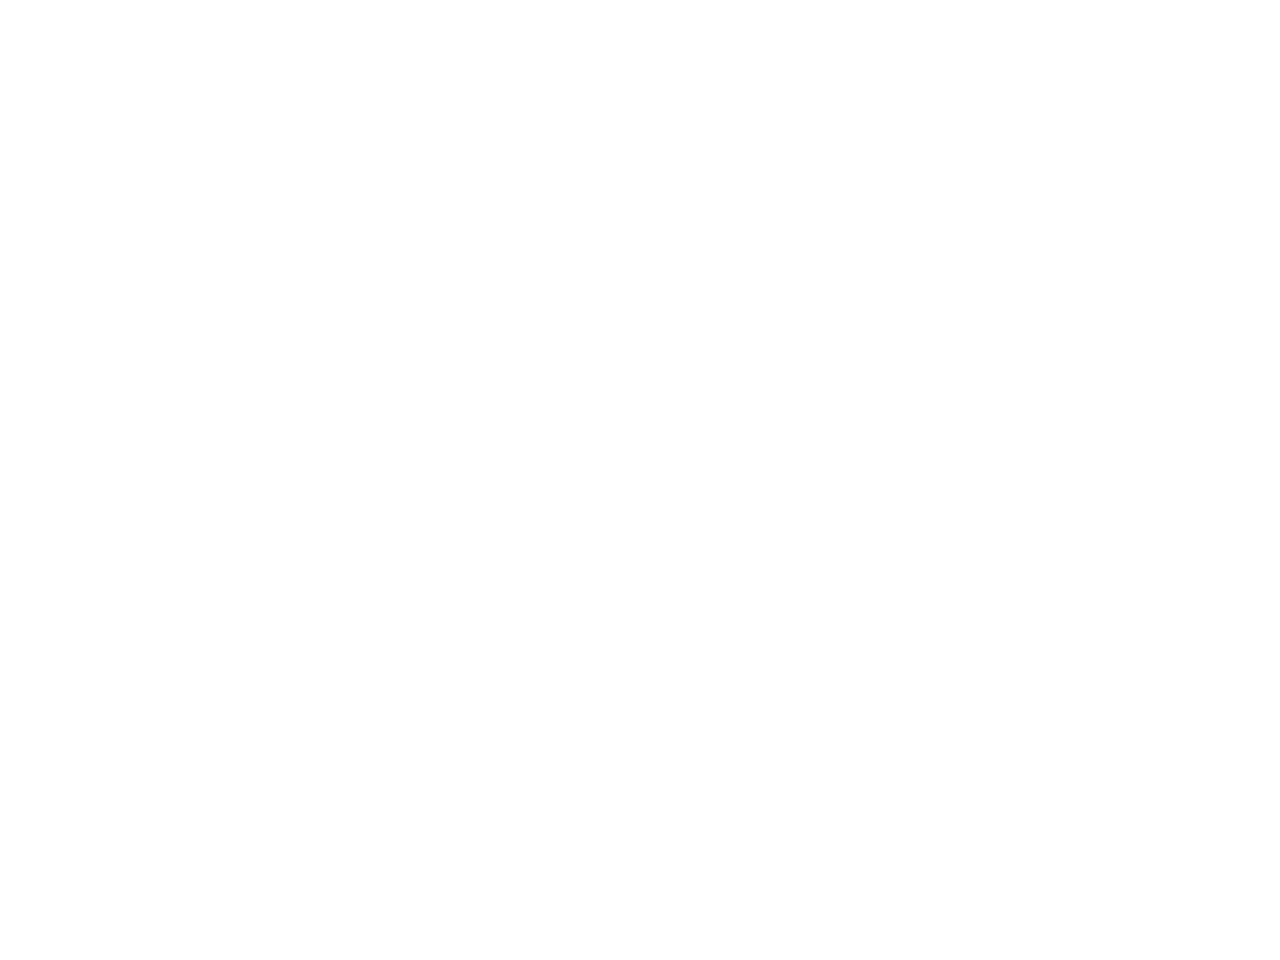

/var/folders/xb/4hhmcv5x1tx29d8pg1tqsjhc0000gn/T/ipykernel_50327/3329422710.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(111, projection='3d')


In [6]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(x)

# try and plot kernel density estimator
n_plot_points = 100
x_vec = np.linspace(-5, 5, n_plot_points)
y_vec = np.linspace(-10, 20, n_plot_points)
X, Y = np.meshgrid(x_vec, y_vec)
w = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)
log_density = kde.score_samples(w)
log_density = log_density.reshape(n_plot_points, n_plot_points)
fig, ax = plt.subplots(num=4)
ax = plt.subplot(111, projection='3d')
ax.plot_surface(X, Y, np.exp(log_density))
plt.show()

Closing thoughts:
- We picked a tough distribution to model here. 
- Note that we didn't have to worry about normalizing the distribution. 